### Optimizing Recall 

The following notebook highlights the work that was done to explore the pos_weight argument of our BCElogitloss function. Increasing pos_weight > 1 means there is a heavier penalization (loss) on positives in attempt to reduce false negatives (a true positive where model predicts is negative) and improve recall. 

## Imports

In [1]:
!pip install captum

In [2]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/cnn-script/cnn_utils.py", dst = "../working/cnn_utils.py")

# import all our functions
from cnn_utils import *

In [3]:
import numpy as np
import pandas as pd 
import os

from torchvision import models, datasets, utils#,transforms
from collections import OrderedDict

from torch import nn, optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch
import os
import math
import os
import matplotlib.pyplot as plt

## Data

In [4]:
IMAGE_SIZE = 300
BATCH_SIZE = 8

TRAIN_DIR = "../input/lipodata/data_split_unmapped/train"
VALID_DIR = "../input/lipodata/data_split_unmapped/val"

train_transforms = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        ToTensorV2(),
        
    ]
)

valid_transforms = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        ToTensorV2(),
        
    ]
)

In [5]:
# create a dataset and tranform the images 
dataset = LipoDataset(TRAIN_DIR, transform=train_transforms)
v_dataset = LipoDataset(VALID_DIR, transform=valid_transforms)
# create a dataloader 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(v_dataset, batch_size=8)

img, label = next(iter(train_loader))
img.shape

torch.Size([8, 3, 300, 300])

## Intialize Model

In [6]:
def make_model():
    densenet = models.densenet121(pretrained=True)
    new_layers = torch.nn.Sequential(OrderedDict([
        ('new1', torch.nn.Linear(1024, 500)),
        ('relu', torch.nn.ReLU()),
        ('new2', torch.nn.Linear(500, 1))
    ]))
    densenet.classifier = new_layers
    torch.manual_seed(2020)
    densenet.apply(weights_init);
    return densenet

In [7]:
# redefine function to return the trained model
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    data_type = torch.float32
    valid_loss = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device,data_type), y.to(device,data_type)
                model.cuda()
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat.to(device), y.type(data_type))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(data_type).sum().item()
        train_accuracy = train_batch_acc / len(train_loader.dataset)
        
        # Validation
        confusion_matrix = torch.zeros(2, 2)
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device,data_type), y.to(device,data_type)
                    model.cuda()
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat.to(device), y.type(data_type))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(data_type).sum().item()
        valid_accuracy = valid_batch_acc / len(valid_loader.dataset)
        valid_loss.append(valid_batch_loss / len(valid_loader))        
        
        with torch.no_grad():
            for i, (inputs, classes) in enumerate(valid_loader):
                inputs = inputs.to(device, data_type)
                classes = classes.to(device, data_type)
                outputs = model(inputs).flatten()
                preds = torch.sigmoid(outputs) > 0.5
                for t, p in zip(classes.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
        recall = confusion_matrix.numpy()[1,1]/(confusion_matrix.numpy()[1,1]+confusion_matrix.numpy()[1,0])
        model.train()
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy:.2f}.",
                  f"Valid Accuracy: {valid_accuracy:.2f}.",
                  f"Valid Recall: {recall:.2f}")
    
    return model

## Positive weight setup

In [8]:
pos_weight2 = torch.ones([1])
pos_weight2[0] = 2
pos_weight2

tensor([2.])

In [9]:
pos_weight1_5 = torch.ones([1])
pos_weight1_5[0] = 1.5
pos_weight1_5 

tensor([1.5000])

In [10]:
pos_weight1_62 = torch.ones([1])
pos_weight1_62[0] = 152/94
pos_weight1_62

tensor([1.6170])

In [11]:
pos_weight1_2 = torch.ones([1])
pos_weight1_2[0] = 1.2
pos_weight1_2

tensor([1.2000])

## Use optimized parameters

In [12]:
best_parameters={'lr': np.round(7.456370422609558e-05, 5), 'beta1': np.round(0.9815918038692326, 3)}
best_parameters

{'lr': 7e-05, 'beta1': 0.982}

## Train Model with High Positive Weight

In [13]:
# pos_weight = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight2.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
pos_weight2_model = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.47. Valid Accuracy: 0.42. Valid Recall: 1.00
Epoch 2: Train Accuracy: 0.59. Valid Accuracy: 0.77. Valid Recall: 0.65
Epoch 3: Train Accuracy: 0.61. Valid Accuracy: 0.53. Valid Recall: 1.00
Epoch 4: Train Accuracy: 0.62. Valid Accuracy: 0.75. Valid Recall: 0.70
Epoch 5: Train Accuracy: 0.65. Valid Accuracy: 0.72. Valid Recall: 0.85
Epoch 6: Train Accuracy: 0.71. Valid Accuracy: 0.70. Valid Recall: 0.90
Epoch 7: Train Accuracy: 0.70. Valid Accuracy: 0.72. Valid Recall: 0.80
Epoch 8: Train Accuracy: 0.69. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 9: Train Accuracy: 0.66. Valid Accuracy: 0.70. Valid Recall: 0.80
Epoch 10: Train Accuracy: 0.70. Valid Accuracy: 0.64. Valid Recall: 0.85
Epoch 11: Train Accuracy: 0.62. Valid Accuracy: 0.66. Valid Recall: 0.90
Epoch 12: Train Accuracy: 0.68. Valid Accuracy: 0.85. Valid Recall: 0.75
Epoch 13: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.65. Valid Accuracy: 0.70. Valid 

In [14]:
# pos_weight = 1.617
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight1_62.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
pos_weight1_62_model = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.54. Valid Accuracy: 0.45. Valid Recall: 1.00
Epoch 2: Train Accuracy: 0.61. Valid Accuracy: 0.68. Valid Recall: 0.70
Epoch 3: Train Accuracy: 0.63. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 4: Train Accuracy: 0.69. Valid Accuracy: 0.77. Valid Recall: 0.60
Epoch 5: Train Accuracy: 0.62. Valid Accuracy: 0.72. Valid Recall: 0.90
Epoch 6: Train Accuracy: 0.67. Valid Accuracy: 0.81. Valid Recall: 0.75
Epoch 7: Train Accuracy: 0.68. Valid Accuracy: 0.68. Valid Recall: 0.85
Epoch 8: Train Accuracy: 0.66. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 9: Train Accuracy: 0.73. Valid Accuracy: 0.75. Valid Recall: 0.80
Epoch 10: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.80
Epoch 11: Train Accuracy: 0.65. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 12: Train Accuracy: 0.72. Valid Accuracy: 0.77. Valid Recall: 0.65
Epoch 13: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.80
Epoch 14: Train Accuracy: 0.70. Valid Accuracy: 0.75. Valid 

In [15]:
# pos_weight = 1.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight1_5.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
pos_weight1_5_model = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.53. Valid Accuracy: 0.51. Valid Recall: 0.95
Epoch 2: Train Accuracy: 0.57. Valid Accuracy: 0.75. Valid Recall: 0.70
Epoch 3: Train Accuracy: 0.69. Valid Accuracy: 0.72. Valid Recall: 0.70
Epoch 4: Train Accuracy: 0.63. Valid Accuracy: 0.77. Valid Recall: 0.80
Epoch 5: Train Accuracy: 0.63. Valid Accuracy: 0.70. Valid Recall: 0.90
Epoch 6: Train Accuracy: 0.66. Valid Accuracy: 0.77. Valid Recall: 0.75
Epoch 7: Train Accuracy: 0.68. Valid Accuracy: 0.79. Valid Recall: 0.80
Epoch 8: Train Accuracy: 0.73. Valid Accuracy: 0.68. Valid Recall: 0.90
Epoch 9: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.85
Epoch 10: Train Accuracy: 0.67. Valid Accuracy: 0.77. Valid Recall: 0.75
Epoch 11: Train Accuracy: 0.66. Valid Accuracy: 0.75. Valid Recall: 0.85
Epoch 12: Train Accuracy: 0.72. Valid Accuracy: 0.77. Valid Recall: 0.85
Epoch 13: Train Accuracy: 0.69. Valid Accuracy: 0.77. Valid Recall: 0.50
Epoch 14: Train Accuracy: 0.68. Valid Accuracy: 0.77. Valid 

In [16]:
# pos_weight = 1.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight1_2.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
pos_weight1_2_model = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.56. Valid Accuracy: 0.42. Valid Recall: 1.00
Epoch 2: Train Accuracy: 0.64. Valid Accuracy: 0.74. Valid Recall: 0.30
Epoch 3: Train Accuracy: 0.65. Valid Accuracy: 0.74. Valid Recall: 0.75
Epoch 4: Train Accuracy: 0.71. Valid Accuracy: 0.77. Valid Recall: 0.65
Epoch 5: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.85
Epoch 6: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.60
Epoch 7: Train Accuracy: 0.65. Valid Accuracy: 0.74. Valid Recall: 0.40
Epoch 8: Train Accuracy: 0.65. Valid Accuracy: 0.77. Valid Recall: 0.80
Epoch 9: Train Accuracy: 0.67. Valid Accuracy: 0.77. Valid Recall: 0.75
Epoch 10: Train Accuracy: 0.67. Valid Accuracy: 0.75. Valid Recall: 0.55
Epoch 11: Train Accuracy: 0.72. Valid Accuracy: 0.74. Valid Recall: 0.80
Epoch 12: Train Accuracy: 0.72. Valid Accuracy: 0.77. Valid Recall: 0.80
Epoch 13: Train Accuracy: 0.68. Valid Accuracy: 0.74. Valid Recall: 0.60
Epoch 14: Train Accuracy: 0.67. Valid Accuracy: 0.72. Valid 

## Train the Model with Normal Weight 

In [17]:
# pos_weight = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
normal_model = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.58. Valid Accuracy: 0.62. Valid Recall: 0.90
Epoch 2: Train Accuracy: 0.64. Valid Accuracy: 0.66. Valid Recall: 0.15
Epoch 3: Train Accuracy: 0.59. Valid Accuracy: 0.77. Valid Recall: 0.75
Epoch 4: Train Accuracy: 0.63. Valid Accuracy: 0.74. Valid Recall: 0.40
Epoch 5: Train Accuracy: 0.63. Valid Accuracy: 0.75. Valid Recall: 0.90
Epoch 6: Train Accuracy: 0.67. Valid Accuracy: 0.77. Valid Recall: 0.55
Epoch 7: Train Accuracy: 0.71. Valid Accuracy: 0.75. Valid Recall: 0.50
Epoch 8: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.50
Epoch 9: Train Accuracy: 0.65. Valid Accuracy: 0.85. Valid Recall: 0.90
Epoch 10: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.35
Epoch 11: Train Accuracy: 0.65. Valid Accuracy: 0.77. Valid Recall: 0.60
Epoch 12: Train Accuracy: 0.69. Valid Accuracy: 0.77. Valid Recall: 0.55
Epoch 13: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.71. Valid Accuracy: 0.74. Valid 

## Test on Holdout sample

In [18]:
TEST_DIR = '../input/lipodata/data_split_unmapped/test'                                               
test_dataset = LipoDataset(TEST_DIR, transform=valid_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [19]:
def final_evaluator(cnn, data_loader):
    acc = get_test_accuracy(cnn, data_loader)
    matrix = pytorch_confusion_matrix(cnn, data_loader)
    recall = recall_calculation(matrix)
    return matrix

In [22]:
def confusion_matrix_eval(cnn, data_loader):
    """retrieves false positives and false negatives for further investigation"""
    fp = []
    fn = []
    cnn.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device, torch.float32)
            classes = classes.to(device, torch.float32)
            outputs = cnn(inputs).flatten()
            preds = torch.sigmoid(outputs) > 0.5
            j = 0
            for t, p in zip(classes.view(-1), preds.view(-1)):
                if [float(t.cpu().numpy()), float(p.long().cpu().numpy())] == [
                    0.0,
                    1.0,
                ]:
                    fp.append(
                        data_loader.dataset.samples[(i * data_loader.batch_size + j)][1]
                    )
                elif [float(t.cpu().numpy()), float(p.long().cpu().numpy())] == [
                    1.0,
                    0.0,
                ]:
                    fn.append(
                        data_loader.dataset.samples[(i * data_loader.batch_size + j)][1]
                    )
                j += 1
        return {"false_positives": fp, "false_negatives": fn}

In [23]:
# pos_weight = 2
final_evaluator(pos_weight2_model, test_loader)

Test accuracy is 72.22%.
Test recall is 80.95%.


predict negative  predict positive
actual negative              22.0              11.0
actual positive               4.0              17.0

In [24]:
# pos_weight = 1.62
final_evaluator(pos_weight1_62_model, test_loader)

Test accuracy is 75.93%.
Test recall is 52.38%.


predict negative  predict positive
actual negative              30.0               3.0
actual positive              10.0              11.0

In [25]:
# pos_weight = 1.5
final_evaluator(pos_weight1_5_model, test_loader)

Test accuracy is 74.07%.
Test recall is 71.43%.


predict negative  predict positive
actual negative              25.0               8.0
actual positive               6.0              15.0

In [26]:
# pos_weight = 1.2
final_evaluator(pos_weight1_2_model, test_loader)

Test accuracy is 74.07%.
Test recall is 47.62%.


predict negative  predict positive
actual negative              30.0               3.0
actual positive              11.0              10.0

In [27]:
final_evaluator(normal_model, test_loader)

Test accuracy is 77.78%.
Test recall is 52.38%.


predict negative  predict positive
actual negative              31.0               2.0
actual positive              10.0              11.0

In [28]:
list_of_models = [pos_weight2_model, pos_weight1_62_model, pos_weight1_5_model, pos_weight1_2_model, normal_model]

recall_list = [recall_calculation(pytorch_confusion_matrix(i, test_loader)) for i in list_of_models]

acc_list = [get_test_accuracy(i, test_loader) for i in list_of_models]

    

summary_df = pd.DataFrame({'pos_weight': [pos_weight2, pos_weight1_62, pos_weight1_5, pos_weight1_2, "None"], 
            'accuracy': acc_list,
            'recall': recall_list
             })

summary_df

Test recall is 80.95%.
Test recall is 52.38%.
Test recall is 71.43%.
Test recall is 47.62%.
Test recall is 52.38%.
Test accuracy is 72.22%.
Test accuracy is 75.93%.
Test accuracy is 74.07%.
Test accuracy is 74.07%.
Test accuracy is 77.78%.


pos_weight  accuracy    recall
0      [tensor(2.)]  0.722222  0.809524
1  [tensor(1.6170)]  0.759259  0.523810
2  [tensor(1.5000)]  0.740741  0.714286
3  [tensor(1.2000)]  0.740741  0.476190
4              None  0.777778  0.523810

## Visualize the False Positives

In [29]:
# get the file images that the model predicting that are false positives
false_positives_dbl = confusion_matrix_eval(pos_weight1_5_model, test_loader)["false_positives"]
false_positives_dbl

['../input/lipodata/data_split_unmapped/test/negative/USLH040_06.jpg',
 '../input/lipodata/data_split_unmapped/test/negative/USLH053_10.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH021_15.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH067_02.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH033_06.jpg',
 '../input/lipodata/data_split_unmapped/test/negative/USLH058_12.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH060_03.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH038_10.jpg']

In [30]:
# source - https://stackoverflow.com/questions/20038648/writting-a-file-with-multiple-images-in-a-grid
# visualize
def display_grid(images_list):
    
    images_count = len(images_list)
    print('False Positive Images count: ', images_count)
    
    # Calculate the grid size:
    grid_size = math.ceil(math.sqrt(images_count))
    
    # Create plt plot
    fig, axes = plt.subplots(grid_size, grid_size, 
                         figsize=(40, 40))
    
    for i in range(images_count):
        x_position = i % grid_size
        y_position = i // grid_size
        
        plt_image = plt.imread(images_list[i])
        axes[x_position, y_position].imshow(plt_image)
        
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

False Positive Images count:  8


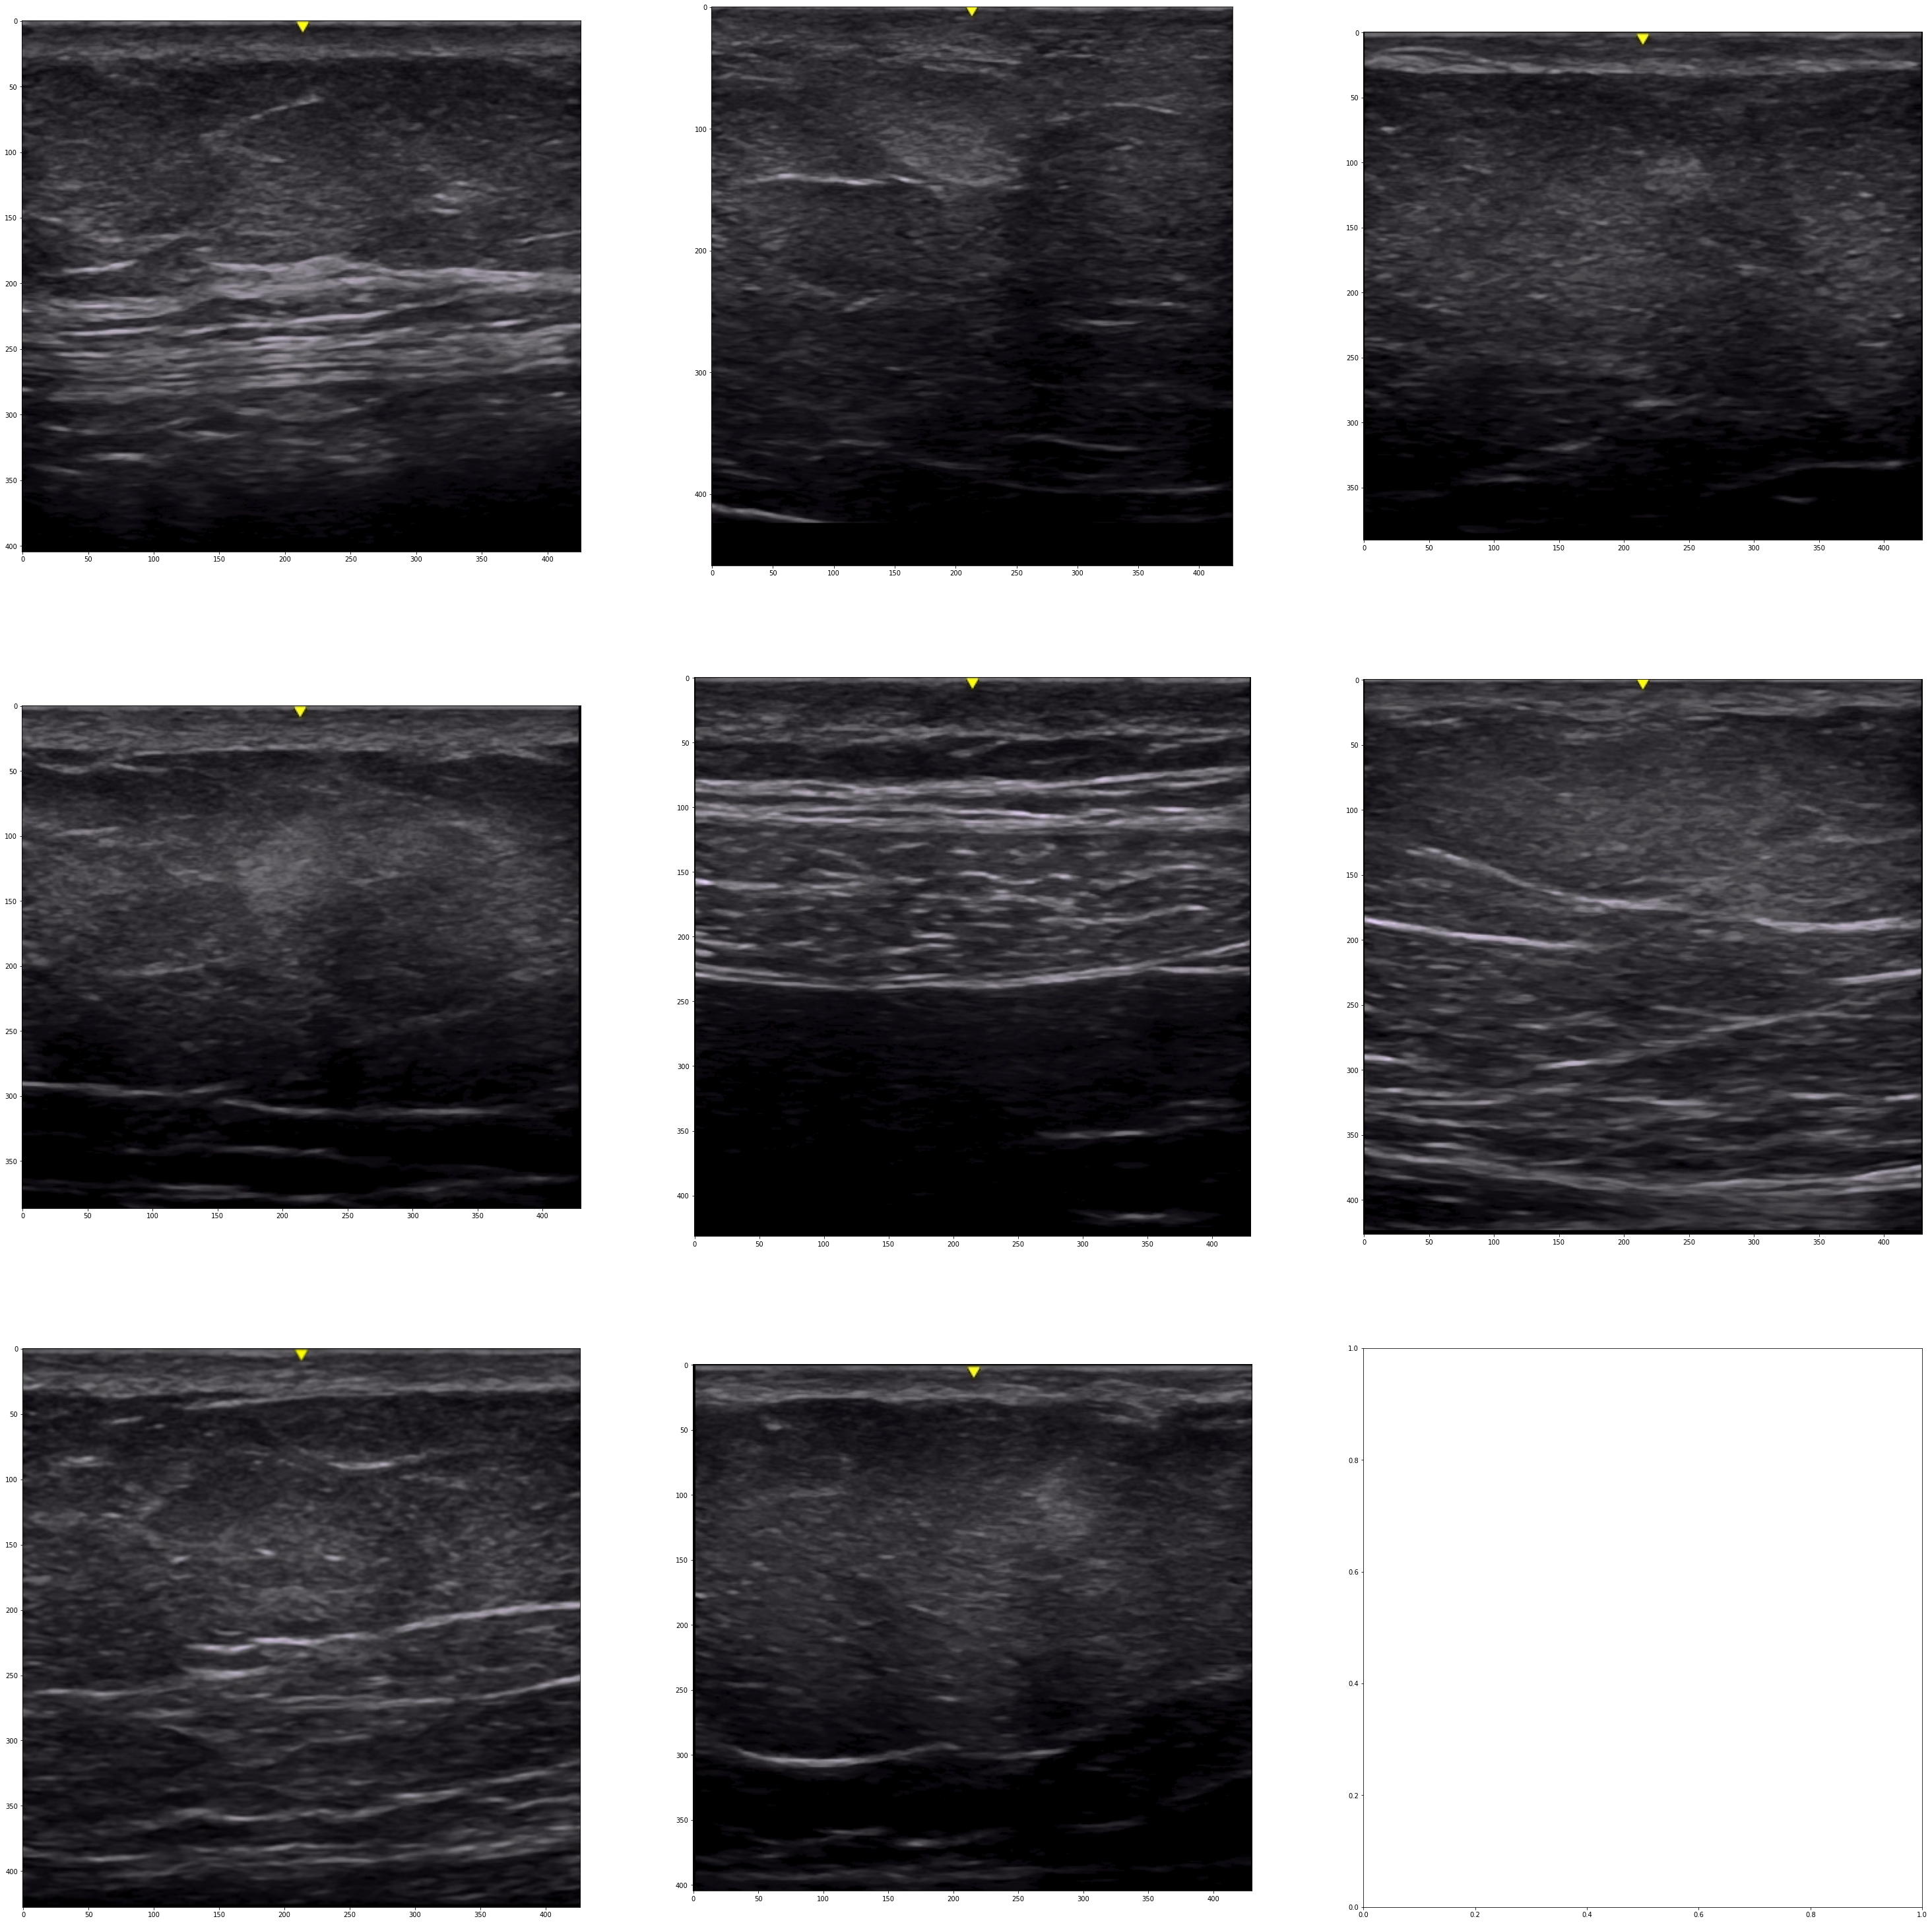

In [31]:
display_grid(false_positives_dbl)